# Case Study 1 - Predicting Superconductors 

__Team Members__

- Name 1: Amber Clark
- Name 2: Andrew Leppla
- Name 3: Jorge Olmos
- Name 4: Paritosh Rai

# Content
* [Business Understanding](#business-understanding)
* [Data Evaluation](#data-evaluation)
    - [Data Understanding](#data-understanding)
    - [Missing Values](#missing-values)
    - [Which Values are needed](#values-needed)
    - [Assumptions](#assumptions)
* [Model Preparations](#model-preparations)
    - [Method](#method)
    - [Evaluation Metrics](#evaluation-metrics)
* [Model Building & Evaluations](#model-building)
    - [Sampling Methodology](#sampling-methodology)
    - [L1 Model](#L1-model)
    - [L2 Model](#L2-model)
    - [Analysis](#analysis)
* [Model Interpretability & Explainability](#model-explanation)
* [Conclusion](#conclusion)

## Executive Summary

### Abstract
The objective of the case study is to identify what elements, characteristics, and exploratory variables correlate to superconductors by identifying relationships with high critical temperatures. This is done by regressing the critical temperature of many superconductors of varying elemental composition based on a range of quantitative material characteristics.

### Introduction
A superconductor is a material that will exhibit extremely low to no electrical resistance at a sufficiently low enough temperature, resulting in infinite conductivity. This still little-understood phenomenon at which a material reaches the physical state of superconductivity occurs suddenly at a temperature known as the critical temperature. In 1911 the Dutch physicist Heike Kamerlingh Onnes discovered Mercury (Hg) as the first superconductor at a critical temperature of 4 degrees Kelvin (or -424 degrees Fahrenheit). Since then, researchers have discovered and developed many superconducting compounds, including metal alloys and ceramics, intending to find materials with higher critical temperatures (or ideally, those as close to room temperature as possible), as the requirement of extreme cooling is both expensive and challenging to achieve.
The dataset contains 21,263 observations of materials. The information for these observations includes the ratios of 77 different elements and 81 quantitative material characteristics of the compounds. The goal is to predict the Critical Temperature and find which combination of these variables can positively or negatively correlate most with increased critical temperature to identify valuable new superconductors' traits.

### Methods
Dataset provided two files containing measurements of material characteristics and another with the elemental compositions. The two files were combined for use in this analysis along with the target response variable, critical temperature. There were no missing values in the data provided for this analysis. The team also identified a few outliers' (82 rows) in the clean-up process. The team worked on a model that will help determine which individual features contribute most to increases in critical temperature. Therefore, linear regression is best for this case as the response variable is continuous. The team split the data as a training set to build the model and a test set to validate the model's outcome. 
After combining the two data files, the data set contained 158 features to start. This dataset was very complex to interpret and drive any kind of correlation and may result in over-fitting the model. After initial exploration of the dataset, the team built a linear model with all 158 features as a baseline. Followed by the linear model using a LASSO algorithm to select the most pertinent variables, and then Ridge regression to fit the model using the smaller set of variables chosen to reduce the chances of overfitting without further reducing the number of variables . The primary objective was to reduce the number of explanatory variables, to build a meaningful model and ensure the accuracy and explain ability of a dependable variable by the independent variable is not compromised.
 The prime criteria to evaluate the model was to minimize the error (mean square error) and increase the explanation of the relationship between independent and dependent variables (r – square). The team also made a few manual adjustments to optimize (trade-off) the model's accuracy and enhance the model interpretation. The team investigated the correlations, checked the multi-collinearity, and kept the most relevant features. 
 
### Results
The coefficients representing the feature importance in the final linear model and the summary table with vital statistics are shown in the figures below.



The team started building the model with the notion of predicting the critical temperature based on   material composition and properties given. Entropy, Thermal Conductivity and Atomic Radius has the high influence on critical temperature (show positive correlation) of superconductors to achieve superconductivity. Also, the presence of Barium (Ba), Calcium (Ca) and Bismuth (Bi) helps increase the critical temperature. 
We observed an interesting result that only around nine (9) features and thirteen (13) materials, out of 158, dominate the outcome. This model could potentially provide the scientific community with some insight to narrow their research to a few key factors and elements.


# Business Understanding <a id='business-understanding'/>



The primary purpose is to research is for the prediction of new superconductors and at the temperature at which they would occur based on the experimental data provided.

We have been provided with two files, once which lists the critical temperature at which the superconductor occurs and the properties associated to the superconductor. A second file maps the materials and breaks down the elements for each of the superconductors. 

Both files contains 21,263 records, with the training file and material files containing 88 variables, and 82 variables respectively. There are no duplicate records, however both the training and materials files contain a duplicate critical_temp column.

Our goal is to create models that predict the __critical temperature__, our target variable, for which a superconductor might occur. To do so we will be creating regression models (Ridge and Lasso), and utilizing different dimensionality reduction techniques to improve training time, avoid overfitting, and take care of multicollinearity. We will be using k-fold cross validation that will help our model have low bias, and evaluating our models using RMSE and an adjusted R^2.




# Data Evaluation <a id='data-evaluation'>
    

The data comes from a Japanese database, Materials Data Repository.  It is a database repository or materials research and publications.  The data we are working with has been used in a variety of analysis and publications available online conducting similar analysis to what we have done in our assignment.

In [ ]:
# standard libraries
import pandas as pd
import numpy as np
import time
import re #regex
from IPython.display import Image

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# data pre-processing
from sklearn.preprocessing import StandardScaler
#from sklearn import preprocessing

# prediction models
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
#from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoLarsIC
from sklearn import metrics as mt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import make_scorer
from kneed import KneeLocator
from scipy import stats

# import warnings filter
import warnings
warnings.filterwarnings('ignore')
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

from tabulate import tabulate

## Loading Data

#### After loading data we noticed that all but three of the characteristics (number of elements, range of atomic mass of radius, range of valence) are floats.

In [ ]:
materials = pd.read_csv('superconduct/unique_m.csv') 
characteristics = pd.read_csv('superconduct/train.csv')

In [ ]:
datadictionary = pd.read_csv('datadictionary.csv') 
col_names = ["Variable", "Description", "Type"]
print(tabulate(datadictionary, headers=col_names, tablefmt='fancy_grid'))

╒════╤═════════════════════════════════╤══════════════════════════════════════════════════════╤═════════╕
│    │ Variable                        │ Description                                          │ Type    │
╞════╪═════════════════════════════════╪══════════════════════════════════════════════════════╪═════════╡
│  0 │ number_of_elements              │ number of elements                                   │ Integer │
├────┼─────────────────────────────────┼──────────────────────────────────────────────────────┼─────────┤
│  1 │ mean_atomic_mass                │ mean of atomic mass                                  │ Float   │
├────┼─────────────────────────────────┼──────────────────────────────────────────────────────┼─────────┤
│  2 │ wtd_mean_atomic_mass            │ weighted mean of atomic mass                         │ Float   │
├────┼─────────────────────────────────┼──────────────────────────────────────────────────────┼─────────┤
│  3 │ gmean_atomic_mass               │ geome

## Missing Data

We looked at both the materials datasets and the train dataset and there appears to be no any missing values.

In [ ]:
materials.isnull().values.any()

False

In [ ]:
characteristics.isnull().values.any()

False

## Exploring Correlations of Features 

We examined the correlations the pair correlations of features, and decided to remove the following three as they made it the final model, yet did not improve the overall perfomance. 

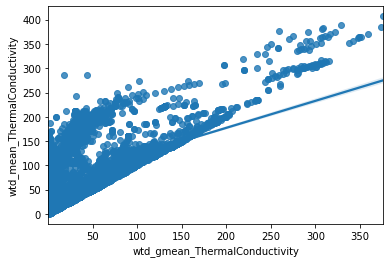

In [ ]:
sns.regplot(y='wtd_mean_ThermalConductivity', x='wtd_gmean_ThermalConductivity', data=characteristics);


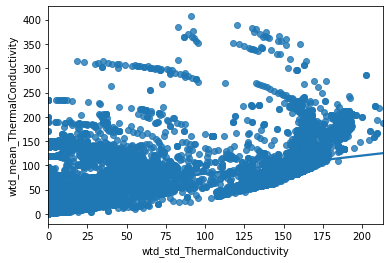

In [ ]:
sns.regplot(y='wtd_mean_ThermalConductivity', x='wtd_std_ThermalConductivity', data=characteristics);

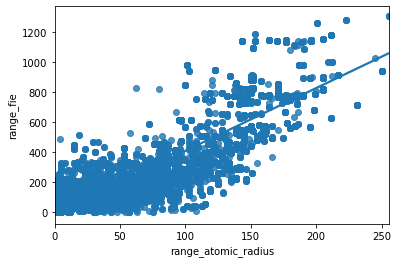

In [ ]:
sns.regplot(x='range_atomic_radius', y='range_fie', data=characteristics);

### Which variables are needed (which ones are not)? 

We removed 9 elements (He', 'Ne', 'Ar', 'Kr', 'Xe', 'Pm', 'Po', 'At', 'Rn') that were not present in any of the materials we examined, therefore they will not contribute to the model. We speculate that the reason for these elements not showing up in any of the materials is that they're noble gases and don't have the propensity to react with any other elements. We additionally removed three characterics ('wtd_gmean_ThermalConductivity', 'wtd_std_ThermalConductivity','range_fie') from our features that were indentified from the multicollinearity analysis and instead kept the features that had higher correlations with the critical temperature.

In [ ]:
describe =  materials.describe()
cols = describe.columns
material_drops = [c for c in cols if describe[c]['max'] == 0.0]
#characteristic_drops = ['wtd_gmean_ThermalConductivity', 'wtd_std_ThermalConductivity','range_fie']
print("Material Drops", material_drops)
print("Characteristics ", characteristic_drops)

Material Drops ['He', 'Ne', 'Ar', 'Kr', 'Xe', 'Pm', 'Po', 'At', 'Rn']
Characteristics  ['wtd_gmean_ThermalConductivity', 'wtd_std_ThermalConductivity', 'range_fie']


In [ ]:
materials = materials.drop(material_drops, axis = 1)
#characteristics = train.drop(characteristic_drops, axis = 1)

##### cleaning up files before combining, critical temp (duplicated in characteristics) and material (unneeded) from materials

In [ ]:
materials = materials.drop(['critical_temp', 'material'], axis = 1)

#### Combining Datasets

In [ ]:
df = pd.concat([materials, characteristics ], axis=1)

## Determining Outliers and Removing Outliers

Outliers of explanatory variables were identified based on visual inspection of boxplots. Outliers were at least twice as far from the next highest point.

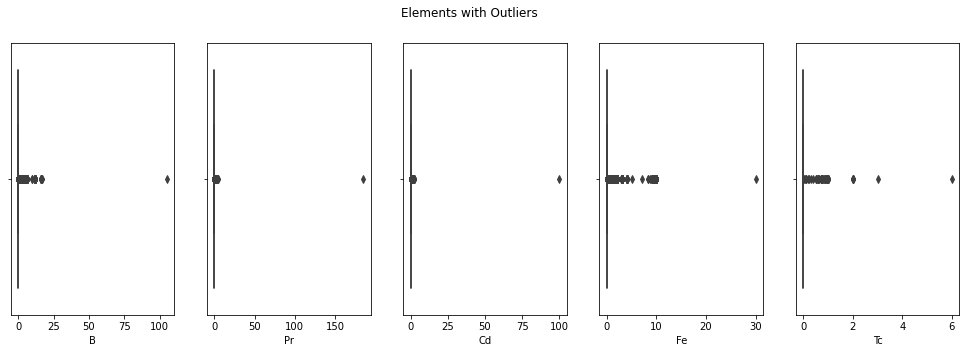

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(17, 5))
fig.suptitle('Elements with Outliers')
outlier_elem = ['B', 'Pr', 'Cd', 'Fe', 'Tc']
for i,j in zip(outlier_elem, range(5)):
    sns.boxplot(ax = axes[j], x = materials[i]); 

In [ ]:

df = df[ df['B'] < df['B'].max() ]
df = df[ df['Pr'] < df['Pr'].max() ]
df = df[ df['Cd'] < df['Cd'].max() ]
df = df[ df['Fe'] < df['Fe'].max() ]
df = df[ df['Tc'] < df['Tc'].max() ]
df = df[ df.index != 5918] # outlier in log transform models
print(df.shape)

(21257, 159)


## Examining Distribution of Target Variable: Critical Temperature

###### Even though it is skewed, our sample size is large enough for the Central Limit Theorm to apply.  We noticed the data is bimodal, which could indicate that there are different relationships for high temperature superconductors and regular superconductors (does not represent 1 population), making data interpretation more dificult.

(check the residuals for normality)

### Distribution of critical temperature 

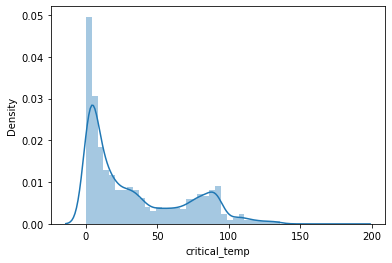

In [ ]:
sns.distplot(df['critical_temp']);

### Distribution of log of critical temperature

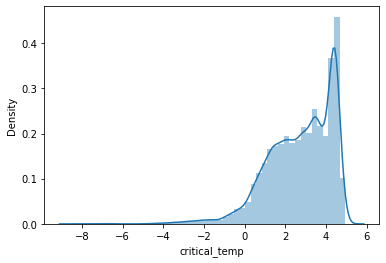

In [ ]:
sns.distplot(np.log(df['critical_temp']));

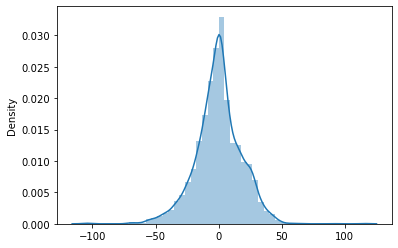

In [ ]:

Image(filename='resid_hist.png') 

# Skew Of Data

In [ ]:
df_skew = train.skew()
df_skew.shape
df_skew.head()
df_skew.loc['wtd_mean_atomic_mass']
transformed_data = train

for col in train.columns:
    if abs(df_skew.loc[col]) > 1:
        print(abs(df_skew.loc[col]),col)
        transformed_data[col]= np.log(train[col])


1.5039066527525764 wtd_mean_atomic_mass
1.474815716460679 gmean_atomic_mass
1.6982799470264731 wtd_gmean_atomic_mass
2.4638078639298486 wtd_range_atomic_mass
1.009764280457501 mean_fie
1.1919286264562294 gmean_fie
1.643162460903729 wtd_range_atomic_radius
2.103343841114579 mean_Density
2.1377633652220895 wtd_mean_Density
1.6591282559918128 gmean_Density
1.6509298548729716 wtd_gmean_Density
3.322725556824231 wtd_range_Density
1.098437437881419 mean_ElectronAffinity
1.3497357705423987 gmean_ElectronAffinity
2.5227818804703905 mean_FusionHeat
2.7638258028710343 wtd_mean_FusionHeat
2.665477197882816 gmean_FusionHeat
2.4875423104652383 wtd_gmean_FusionHeat
2.7485818063583047 range_FusionHeat
4.233613879127433 wtd_range_FusionHeat
2.822554806107452 std_FusionHeat
2.850133800691453 wtd_std_FusionHeat
1.379703282816514 wtd_mean_ThermalConductivity
2.3399514687914174 gmean_ThermalConductivity
2.588304794394417 wtd_gmean_ThermalConductivity
1.4159181865406276 wtd_range_ThermalConductivity
1.0036

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Scaling Data

In [ ]:
# Define y and X
y = np.array( df['critical_temp'] )
df = df.drop(['critical_temp'], axis =1)
X = df

### Using Standard Scaler to scale train data.

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1234321) 

# Center and Scale X
scl = StandardScaler()
scl.fit(X_train)
X_train_scaled = scl.transform(X_train) # apply to training
X_test_scaled = scl.transform(X_test) # apply to the test set (without snooping)

In [ ]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X.columns, index = X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X.columns, index = X_test.index)

## Assumptions

### Target Variable interpretation

According to our research, the Kelvin temperature scale is used for temperature instead of Fahrenheit or Celsius in semiconductor research and manufacturing.  Scientists and engineers use the Kelvin scale because it is a temperature scale where the value zero reflects the complete absence of thermal energy.  The Kelvin scale does not have negative temperatures since 0 degrees kelvin is the lowest temperature.  Because negative temperatures do not exist on the Kelvin scale, in our modeling, we replaced negative predicted values with 0.

## Move up to EDA
## Variable Correlations with Critical Temp & Outliers

In [ ]:
print(train[train.columns[1:]].corr()['critical_temp'][:-1].sort_values())

wtd_mean_Valence              -0.632401
wtd_gmean_Valence             -0.615653
mean_Valence                  -0.600085
gmean_Valence                 -0.573068
gmean_Density                 -0.541684
                                 ...   
wtd_entropy_atomic_mass        0.626930
std_ThermalConductivity        0.653632
range_atomic_radius            0.653759
range_ThermalConductivity      0.687654
wtd_std_ThermalConductivity    0.721271
Name: critical_temp, Length: 80, dtype: float64


In [ ]:
outliers = pd.DataFrame()
for col in train.columns:
    col_zscore = col + "_zscore"
    outliers[col_zscore] = (train[col] - train[col].mean())/train[col].std(ddof=0)
outliers.head()

,number_of_elements_zscore,mean_atomic_mass_zscore,wtd_mean_atomic_mass_zscore,gmean_atomic_mass_zscore,wtd_gmean_atomic_mass_zscore,entropy_atomic_mass_zscore,wtd_entropy_atomic_mass_zscore,range_atomic_mass_zscore,wtd_range_atomic_mass_zscore,std_atomic_mass_zscore,...,wtd_mean_Valence_zscore,gmean_Valence_zscore,wtd_gmean_Valence_zscore,entropy_Valence_zscore,wtd_entropy_Valence_zscore,range_Valence_zscore,wtd_range_Valence_zscore,std_Valence_zscore,wtd_std_Valence_zscore,critical_temp_zscore
0,-0.080058,0.046733,-0.451651,-0.158850,-0.611819,0.044358,-0.003707,0.133725,-0.053039,0.378186,...,-0.752156,-0.805912,-0.711705,0.186292,0.035183,-0.837959,-0.406166,-0.838372,-0.520070,-0.158267
1,0.614744,0.174269,-0.432071,0.059368,-0.604180,0.777430,-0.015267,0.133725,0.108900,0.134901,...,-0.752156,-1.116731,-0.719454,0.664971,-0.014779,-0.033011,-0.362352,-0.426866,-0.450821,-0.245849
2,-0.080058,0.046733,-0.450978,-0.158850,-0.611658,0.044358,-0.218984,0.133725,0.093294,0.378186,...,-0.740164,-0.805912,-0.700728,0.186292,-0.062235,-0.837959,-0.376957,-0.838372,-0.503304,-0.450208
3,-0.080058,0.046733,-0.451314,-0.158850,-0.611739,0.044358,-0.103615,0.133725,0.020128,0.378186,...,-0.746160,-0.805912,-0.706224,0.186292,-0.010538,-0.837959,-0.391562,-0.838372,-0.511524,-0.362626
4,-0.080058,0.046733,-0.452324,-0.158850,-0.611980,0.044358,0.162775,0.133725,-0.199372,0.378186,...,-0.764149,-0.805912,-0.722618,0.186292,0.113627,-0.837959,-0.435376,-0.838372,-0.538178,-0.333432


## Add "Naive" Linear Model with all terms as our baseline model

## Feature Selection
### Add description

In [ ]:
Lasso_df = []
L1 = Lasso()

for i in np.linspace(0, 5, 101):
    L1.alpha = i
  
    # Cross validation on training set
    L1_CV = cross_validate(L1, X_train_scaled, y_train, cv = 5, scoring=['neg_root_mean_squared_error','r2'])
    L1_CV_RMSE = round(np.mean(-L1_CV['test_neg_root_mean_squared_error']), 3)
    L1_CV_Rsq = round(np.mean(L1_CV['test_r2']), 4)
    
    L1.fit(X_train_scaled, y_train)
    num_terms = len(L1.coef_[L1.coef_!=0])
    
    Lasso_df.append([ L1.alpha, num_terms, L1_CV_RMSE, L1_CV_Rsq ])
    
Lasso_df = pd.DataFrame(Lasso_df, columns = ['Lasso alpha', '# Terms', 'CV RMSE', 'CV R-squared'])

#### Finding the point of diminishing returns by identifying Knee Points 

##### Knee point of CV RMSE and # of terms

In [ ]:
kn1 = KneeLocator(Lasso_df['CV RMSE'], Lasso_df['# Terms'], curve='convex', direction='decreasing')
print('CV RMSE', kn1.knee)

CV RMSE 18.214


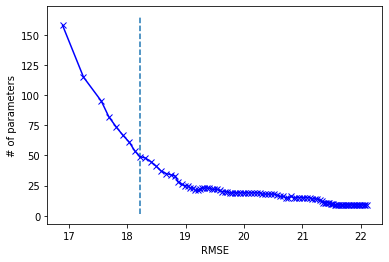

In [ ]:
# Plot number of parameters vs. RMSE

plt.xlabel('RMSE')
plt.ylabel('# of parameters')
plt.plot(Lasso_df['CV RMSE'], Lasso_df['# Terms'], 'bx-')
plt.vlines(kn1.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

##### Knee point  of R-squared and # of terms

In [ ]:
kn2 = KneeLocator(Lasso_df['CV R-squared'],  Lasso_df['# Terms'], curve='convex', direction='increasing')
print('CV R-squared', kn2.knee)

CV R-squared 0.6942


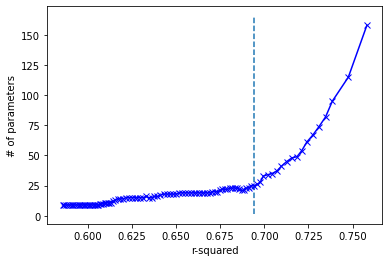

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel('r-squared')
plt.ylabel('# of parameters')
plt.plot(Lasso_df['CV R-squared'], Lasso_df['# Terms'], 'bx-')
plt.vlines(kn2.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

##### Knee point of Alpha and RMSE

In [ ]:
kn3 = KneeLocator(Lasso_df['Lasso alpha'],Lasso_df['CV RMSE'], curve='concave', direction='increasing', S=0)
print('Lasso alpha', kn3.knee)

Lasso alpha 0.9


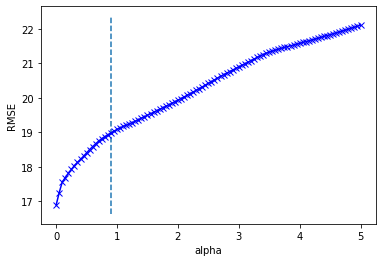

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.plot(Lasso_df['Lasso alpha'],Lasso_df['CV RMSE'], 'bx-')
plt.vlines(kn3.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

##### Knee point of Alpha and R-squared

In [ ]:
kn4 = KneeLocator(Lasso_df['Lasso alpha'],Lasso_df['CV R-squared'], curve='convex', direction='decreasing')
print('Lasso alpha', kn4.knee)

Lasso alpha 0.8500000000000001


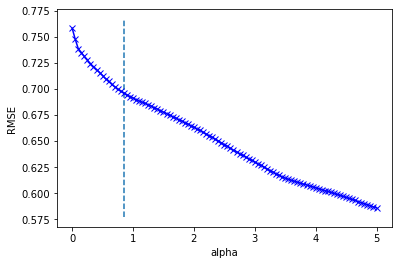

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.plot(Lasso_df['Lasso alpha'],Lasso_df['CV R-squared'], 'bx-')
plt.vlines(kn4.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

# Model Preparations <a id='model-preparations'>

### Which methods are you proposing to utilize to solve the problem?  

After combining the two data files, the data set contained 158 features to start. This dataset was very complex to interpret and drive any kind of correlation, which may result in over-fitting the model. After initial exploration of the dataset, the team built a linear model with all 158 features as a baseline. Followed by the linear model using a LASSO algorithm to select the most pertinent variables, and then Ridge regression to fit the model using the smaller set of variables chosen to reduce the chances of overfitting without further reducing the number of variables. 

The primary objective was to reduce the number of explanatory variables, to build a meaningful model and ensure the accuracy and explain ability of a dependable variable by the independent variable is not compromised.

### Why is this method appropriate given the business objective?

quick, fast to compute and iterpretable 

### How will you determine if your approach is useful (or how will you differentiate which approach is more useful than another)?  More specifically, what evaluation metrics are most useful given that the problem is a regression one (ex., RMSE, logloss, MAE, etc.)?

 The prime criteria to evaluate the model was to minimize the error (mean square error) and increase the explanation of the relationship between independent and dependent variables (r – square). The team also made a few manual adjustments to optimize (trade-off) the model's accuracy and enhance the model interpretation. The team investigated the correlations, checked the multicollinearity, and kept the most relevant features. 

## Select model terms with Lasso

In order reduce the number of parameters we wanted to find the point at which rmse and r^2 begins to flatten after  each additional paramater is added. This is the point of dimishing returns. Depending on what measurement is maximized we can return diffent values for penalizing the model (alpha). Based on our modeling we believe the point of dimishing returns to maximize the r^2 is alpha=0.9. The point of diminishing returns for RMSE is an alpha of 0.85.

In [ ]:
L1 = Lasso(alpha = .9)
L1.fit(X_train_scaled, y_train)

y_hat_train = L1.predict(X_train_scaled)
RMSE = round(mse(y_train, y_hat_train, squared=False), 2)
print( "Lasso Training RMSE =", round(RMSE,2) )
Rsq = r2_score(y_train, y_hat_train)
print( "Lasso Training R-Sq =", round(Rsq,3) )

y_hat_test = L1.predict(X_test_scaled)
RMSE = round(mse(y_test, y_hat_test, squared=False), 2)
print( "\nLasso Test RMSE =", round(RMSE,2) )
Rsq = r2_score(y_test, y_hat_test)
print( "Lasso Test R-Sq =", round(Rsq,3) )

model_coef = pd.DataFrame(zip(X.columns, L1.coef_), columns=['Factor','Coef'])
model_factors = model_coef[model_coef['Coef']!=0]

print("\nKept Factors(", model_factors.shape[0], "of", X.shape[1],"):")
model_coef[model_coef['Coef']!=0].sort_values(by='Coef')

Lasso Training RMSE = 18.87
Lasso Training R-Sq = 0.698

Lasso Test RMSE = 18.44
Lasso Test R-Sq = 0.706

Kept Factors( 25 of 158 ):


,Factor,Coef
157,wtd_std_Valence,-3.551243
121,wtd_gmean_ElectronAffinity,-3.256133
11,Si,-2.542338
110,gmean_Density,-1.791377
53,Pr,-1.664248
141,wtd_gmean_ThermalConductivity,-1.336341
29,As,-0.801547
137,wtd_std_FusionHeat,-0.710089
52,Ce,-0.656177
54,Nd,-0.464878


In [ ]:
# Set any negative predictions to 0 and reassess performance.  
# Cannot have negative degrees Kelvin as mentioned previously in the Assumptions section. 

y_hat_train[y_hat_train<0]=0
RMSE = round(mse(y_train, y_hat_train, squared=False), 2)
print( "\nLinReg Training RMSE =", round(RMSE,2) )
Rsq = r2_score(y_train, y_hat_train)
print( "LinReg Training R-Sq =", round(Rsq,3) )

y_hat_test[y_hat_test<0]=0
RMSE = round(mse(y_test, y_hat_test, squared=False), 2)
print( "\nLinReg Test RMSE =", round(RMSE,2) )
Rsq = r2_score(y_test, y_hat_test)
print( "LinReg Test R-Sq =", round(Rsq,3) )


LinReg Training RMSE = 18.77
LinReg Training R-Sq = 0.702

LinReg Test RMSE = 18.36
LinReg Test R-Sq = 0.709


##### Removing attributes that have collinearity

In [ ]:
model_factors= model_factors[model_factors['Factor'] != 'wtd_gmean_ThermalConductivity']
model_factors= model_factors[model_factors['Factor'] != 'wtd_std_ThermalConductivity']
model_factors= model_factors[model_factors['Factor'] != 'range_fie']

# Model Building & Evaluations <a id='#model-building'>

### Specify your sampling methodology

### Setup your model(s) 
## Final Ridge Model Built from Lasso Model Selection -- Setup your model(s) 

Describe model
specifying the regularization type chosen and including the parameters utilized by the model


In [ ]:
L2 = Ridge(alpha = .9)
model_terms = list(model_factors['Factor'])
L2.fit(X_train_scaled[model_terms], y_train)

y_hat_train = L2.predict(X_train_scaled[model_terms])
y_hat_train[y_hat_train<0]=0
RMSE = round(mse(y_train, y_hat_train, squared=False), 2)
print( "Ridge Training RMSE =", round(RMSE,2) )
Rsq = r2_score(y_train, y_hat_train)
print( "Ridge Training R-Sq =", round(Rsq,3) )

y_hat_test = L2.predict(X_test_scaled[model_terms])
y_hat_test[y_hat_test<0]=0
RMSE = round(mse(y_test, y_hat_test, squared=False), 2)
print( "\nRidge Test RMSE =", round(RMSE,2) )
Rsq = r2_score(y_test, y_hat_test)
print( "Ridge Test R-Sq =", round(Rsq,3) )

model_coef1 = pd.DataFrame(zip(X[model_terms].columns, L2.coef_), columns=['Factor','Coef'])
model_factors1 = model_coef[model_coef['Coef']!=0]

print("\nKept Factors(", model_factors1.shape[0], "of", X.shape[1],"):")
model_coef1[model_coef1['Coef']!=0].sort_values(by=['Coef'])

Ridge Training RMSE = 18.55
Ridge Training R-Sq = 0.709

Ridge Test RMSE = 18.09
Ridge Test R-Sq = 0.717

Kept Factors( 25 of 158 ):


,Factor,Coef
21,wtd_std_Valence,-5.503262
0,Si,-4.148167
17,gmean_Density,-3.782411
18,wtd_gmean_ElectronAffinity,-3.090151
19,wtd_std_FusionHeat,-3.012947
3,As,-2.541149
8,Pr,-2.285263
7,Ce,-1.265167
2,Ge,-1.206696
9,Nd,-1.143237


In [ ]:
model_coef1['abs_Coef'] = abs(model_coef1['Coef'])
model_coef1.sort_values(by=['abs_Coef'])

,Factor,Coef,abs_Coef
5,Ag,-0.888208,0.888208
9,Nd,-1.143237,1.143237
14,range_atomic_mass,1.148657,1.148657
2,Ge,-1.206696,1.206696
7,Ce,-1.265167,1.265167
11,Tl,1.354964,1.354964
10,Hg,1.385003,1.385003
15,mean_fie,1.487692,1.487692
4,Sr,1.985897,1.985897
8,Pr,-2.285263,2.285263


### Analyze your model's performance - referencing your chosen evaluation metric (including supplemental visuals and analysis where appropriate)


71 percent of the variation can be explained by our features. Our model error (rmse) was 18 degrees K. 

# Model Interpretability & Explainability <a id='model-explanation'>

## Which variable(s) was (were) "most important" and why?


Given that our inputs were scaled, we derived the importance of each variable based on the magnitude of the feature coefficients in the model. Features with positive coefficients drive the critical temperature upwards, while features with negative coefficients drive the critical temperature downwards.

Variables related to Atomic Mass, Thermal Conductivity and Atomic Radius have a high positive influence on critical temperature (show positive correlation) of superconductors to achieve superconductivity. Also, the presence of Barium (Ba), Calcium (Ca) and Bismuth (Bi) helps increase the critical temperature. All these variables have the highest scaled coefficients in our model. 

Variables related to Valence, Density, Electron Affinity, and Fusion Heat have a high negative influence on critical temperatures. Additionally the presence of Silicon (Si), Arsenic (As), Praseodymium (Pr) decrease the critical temperature.



In [ ]:
model_coef1.sort_values(by=['Coef'])

,Factor,Coef,abs_Coef
21,wtd_std_Valence,-5.503262,5.503262
0,Si,-4.148167,4.148167
17,gmean_Density,-3.782411,3.782411
18,wtd_gmean_ElectronAffinity,-3.090151,3.090151
19,wtd_std_FusionHeat,-3.012947,3.012947
3,As,-2.541149,2.541149
8,Pr,-2.285263,2.285263
7,Ce,-1.265167,1.265167
2,Ge,-1.206696,1.206696
9,Nd,-1.143237,1.143237


## How did you come to the conclusion and how should your audience interpret this?

# Conclusion <a id='conclusion'>
    


The goal of our analysis was to predict the critical temperature for superconductors.  Determining the critical temperature is important because if superconductors don't cool down below a certain temperature, they lose their conductivity.  The team built a linear model after using LASSO select features. 

### After all of your technical analysis and modeling; what are you proposing to your audience and why? 

We're proposing a linear regression model with L1 and L2 regularization, to reduce the number of features and prevent overfitting, that predicts the critical temperatures using 9 material characteristics and 13 elements out of the 158 total features (81 materical characteristics and 77 elements) provided. Our model achieved and r-squared of 0.72 and an RMSE of 18 degrees K. One of our primary goals was to achieve high model interpretability and reduce the model complexity while at the same time minimizing impact on model performance.  


### How should they view your results and what should they consider when moving forward? 

Attempt to build two separate models for low and high temperature superconductors. We noticed that our observations might come from two separate populations since distribution appears to be bimodal. This in turn would reduce the rmse of each model.


### Are there other approaches you'd recommend exploring?  This is where you "bring it all home" in language they understand.


The team also recommends exploring nonlinear modeling (e.g. boosted trees, random forest) to better handle skewness and outliers in the data
